In [1]:
!pip3 install nufeb-tools -U --quiet

In [1]:
#Imports
import os
from random import uniform
import subprocess
from pathlib import Path
from nufeb_tools import utils,plot
import pandas as pd
from string import Template
import numpy as np
from functools import partial
import time
from skopt import gp_minimize, forest_minimize, dummy_minimize, gbrt_minimize
from skopt.plots import plot_convergence, plot_objective
import matplotlib.pyplot as plt
from scipy import interpolate
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error 
from skopt import dump, load
from skopt.callbacks import CheckpointSaver

In [2]:
test_data = pd.read_excel('../experimental-data/sucrose-OD-IPTG-sweep.xls',sheet_name='data')
from scipy.optimize import curve_fit
def od_func(x):
    """Exponential fit to IPTG vs OD750 experimental data

    Args:
        x (float): IPTG concentration (mM)

    Returns:
        float: Smoothed OD750
    """
    return 0.25482 * np.exp(-x/.06811) + 1.12893
def suc_func(x,a,b,c):
    return a*np.exp(-x/b)+c
# Smooth OD750 data for fitting
test_data.loc[:,'OD750'] = od_func(test_data.IPTG)
#popt, pcov = curve_fit(suc_func, test_data.IPTG, test_data.Sucrose)
    #Compare output with experimental data
#OD = interpolate.interp1d(test_data.IPTG,test_data.OD750)
#Sucrose = interpolate.interp1d(test_data.IPTG,test_data.Sucrose)
#sim = interpolate.interp1d(df.Hours.to_numpy(),df.OD600.to_numpy())
#x_range = np.arange(0,1,.01)
#plt.plot(x_range,suc_func(x_range))
#plt.plot(test_data.IPTG,test_data.Sucrose,marker='o')
#plt.plot(x_range, suc_func(x_range, *popt), 'r-')
#xr = np.array([0.001,.01,.05,0.2,1])
#plt.plot(xr,suc_func(xr, *popt),marker='s',ls='')
#plt.plot(x_range,od_func(x_range))
#residual = abs(r2_score(exp(x_range),sim(x_range))-1)

In [3]:
# Base install of NUFEB
os.chdir('/tmp')
os.system('git clone https://github.com/Jsakkos/NUFEB --recursive')
os.chdir('NUFEB')
os.system('git checkout cyano')
initial_compile = subprocess.run('/home/12x/init-compile.sh')


In [5]:
#nufeb_compile = subprocess.run('/home/12x/rapid-compile.sh')


In [4]:
def recompile(alpha,tau,c,alpha2,tau2,c2):
    os.chdir('/tmp/NUFEB')
    filein = open( f'/home/12x/nufeb-cyano-e-coli/templates/fix_bio_kinetics_monod2.txt' )
    #read it
    src = Template( filein.read() )
    #do the substitution
    result = src.safe_substitute({'alpha' : alpha, 'tau' : tau, 'c' : c,'alpha2' : alpha2, 'tau2' : tau2, 'c2' : c2
                                        
                                        })
    with open("/tmp/NUFEB/src/USER-NUFEB/fix_bio_kinetics_monod.cpp","w") as f:
       f.writelines(result)
    #Compile NUFEB
    nufeb_compile = subprocess.run('/home/12x/rapid-compile.sh')

In [5]:
def test_run():
    os.chdir('/tmp/NUFEB')
    os.system('nufeb-clean')
    text = f'nufeb-seed --cells 100,0 --d 1e-4,1e-4,1e-4 --grid 20 --t 8700'
    os.system(text)
    run_nufeb = subprocess.run('/home/12x/optim2.sh', stdout=subprocess.DEVNULL)

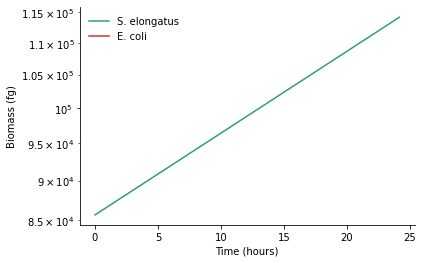

In [8]:
# Test to make sure everything is working
recompile(.18,.07,.8,.79,9.9,.01)
test_run()
BASE_DIR = Path(f'runs/')
folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]
data = [utils.get_data(directory=str(x)) for x in folders]
f, ax = plt.subplots()
plot.overall_growth(data[0].biomass,ax=ax)
plt.show()

In [9]:
from tqdm.notebook import tqdm

class tqdm_skopt(object):
    def __init__(self, **kwargs):
        self._bar = tqdm(**kwargs)
        
    def __call__(self, res):
        self._bar.update()

In [10]:
def func(x):

    alpha = x[0]
    tau = x[1]
    c = x[2]
    #alpha2= 0.7917548932118175
    #tau2= 9.928116064234674
    #c2= 0.017154626440951674
    alpha2 = x[3]
    tau2 = x[4]
    c2 = x[5]
    mu = x[6]





    #Change input params
    
    os.chdir('/tmp/NUFEB')
    recompile(alpha,tau,c,alpha2,tau2,c2)
    print(f'alpha: {alpha},tau: {tau},c: {c},alpha2: {alpha2},tau2: {tau2},c2: {c2}, mu: {mu}')

    #Clean old simulations
    os.system('nufeb-clean')
    #Run simulation
    for iptg in test_data.IPTG:
        text = f'nufeb-seed --cells 10,0 --d 1e-4,1e-4,1e-5 --t 8700 --mucya {mu} --sucR {iptg}'
        os.system(text)

    run_nufeb = subprocess.run('/home/12x/optim2.sh', stdout=subprocess.DEVNULL)
    BASE_DIR = Path(f'runs/')
    folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]

    #Extract output

    data = [utils.get_data(directory=str(x)) for x in folders]
    Volume = 1e-4*1e-4*1e-4 #m^3
    CellNum2OD = Volume*1e6/0.3e-8
    SucroseMW = 342.3
    dfs = []
    for x in data:
        temp = pd.concat([x.ntypes.cyano/CellNum2OD,x.ntypes.step/60/60*x.timestep,x.avg_con.Sucrose.reset_index(drop=True)],axis=1)
        temp.columns=['OD750','Hours','Sucrose']
        temp['IPTG'] = x.metadata['SucRatio']
        dfs.append(temp)
    df = pd.concat(dfs,ignore_index=True)
    df = df.loc[(df.Hours > 23.8) & (df.Hours < 24)]
    df.sort_values(by='IPTG',inplace=True)
    df.reset_index(inplace=True)
    
    #plot
    f, ax = plt.subplots(ncols=2)
    ax[0].set_title('Sucrose')
    ax[0].plot(test_data.IPTG,test_data.Sucrose,marker='o')
    ax[0].plot(df.IPTG,df.Sucrose)
    ax[1].set_title('OD750')
    ax[1].plot(test_data.IPTG,test_data.OD750,marker='o')
    ax[1].plot(df.IPTG,df.OD750)
    plt.show()
    #Compare output with experimental data via RMSE
    
    return mean_squared_error(df.OD750,test_data.OD750, squared = False) + mean_squared_error(df.Sucrose,test_data.Sucrose, squared = False)




In [7]:
res = load('/home/12x/nufeb-cyano-e-coli/checkpoints/checkpoint-se.pkl')
x0 = res.x_iters
y0 = res.func_vals
base_estimator = res.specs['args']['base_estimator']
random_state = res.random_state
          #  x0=x0,              # already examined values for x
       #     y0=y0,              # observed values for x0

In [ ]:

alpha_min = float('-1e0')
alpha_max = float('0')
tau_min = float('0')
tau_max = float('1e0')
c_min = float('-1e1')
c_max = float('5e-1')
alpha2_min = float('-1e1')
alpha2_max = float('1e-1')
tau2_min = float('0')
tau2_max = float('1e0')
c2_min = float('0')
c2_max = float('1e1')

mu_min = float('1e-6')
mu_max = float('5e-5')

bounds = [(alpha_min,alpha_max),(tau_min,tau_max),(c_min,c_max),(alpha2_min,alpha2_max),(tau2_min,tau2_max),(c2_min,c2_max),(mu_min,mu_max)]#,



checkpoint_saver = CheckpointSaver('/home/12x/nufeb-cyano-e-coli/checkpoints/checkpoint-se2.pkl', compress=9) # keyword arguments will be passed to `skopt.dump`
n_calls = 200
#res = forest_minimize(func, bounds, n_calls=n_calls,callback=[tqdm_skopt(total=n_calls, desc="Random forest")],base_estimator="ET",verbose=True)
res = gp_minimize(func, bounds, n_calls=n_calls,verbose=True,
                  callback=[checkpoint_saver])

Iteration No: 1 started. Evaluating function at random point.
alpha: -0.5728407946783137,tau: 0.5335097559243281,c: -9.577401385644146,alpha2: -6.36283530554098,tau2: 0.9772465725071923,c2: 4.971016319012707, mu: 3.3969351843132475e-05


In [ ]:
plot_convergence(res,yscale='log')

In [ ]:
plot_objective(res)

In [ ]:
res.x

In [ ]:
"""
os.chdir('/tmp/NUFEB')
recompile(res.x[0],res.x[1],res.x[2],res.x[3],res.x[4],res.x[5])

#Clean old simulations
os.system('nufeb-clean')
#Run simulation
for iptg in test_data.IPTG:
    text = f'nufeb-seed --cells 100,0 --d 1e-4,1e-4,1e-4 --grid 20 --t 8700 --mucya {res.x[6]} --sucR {iptg}}'
    os.system(text)

run_nufeb = subprocess.run('/home/12x/optim2.sh', stdout=subprocess.DEVNULL)
BASE_DIR = Path(f'runs/')
folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]

#Extract output

data = [utils.get_data(directory=str(x)) for x in folders]
Volume = 1e-4*1e-4*1e-4 #m^3
CellNum2OD = Volume*1e6/0.3e-8
SucroseMW = 342.3
dfs = []
for x in data:
    temp = pd.concat([x.ntypes.cyano/CellNum2OD,x.ntypes.step/60/60*x.timestep,x.avg_con.Sucrose.reset_index(drop=True)],axis=1)
    temp.columns=['OD750','Hours','Sucrose']
    temp['IPTG'] = x.metadata['SucRatio']
    dfs.append(temp)
df = pd.concat(dfs,ignore_index=True)
df = df.loc[(df.Hours > 23.8) & (df.Hours < 24)]
df.sort_values(by='IPTG',inplace=True)
df.reset_index(inplace=True)
"""

In [ ]:
#f, ax = plt.subplots(ncols=2)
#ax[0].set_title('Sucrose')
#ax[0].plot(test_data.IPTG,test_data.Sucrose,marker='o')
#ax[0].plot(df.IPTG,df.Sucrose)
#ax[1].set_title('OD750')
#ax[1].plot(test_data.IPTG,test_data.OD750,marker='o')
#ax[1].plot(df.IPTG,df.OD750)

In [ ]:
os.system('rm -R /tmp/NUFEB')